In [1]:
# import
import numpy as np
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots
import matplotlib.pyplot as plt
import similarity_metrics as sm
from sklearn.model_selection import train_test_split
import scipy.io
import utils.starplus_utils as starp
from numpy.linalg import norm
from tensor.utils import assert_compatile_sizes_modek, reshape, make_axis_iterable
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from matplotlib.cm import ScalarMappable
from numpy.linalg import svd
from tensor.mode_k import modek_unfold
from sklearn.utils.extmath import randomized_svd
from scipy.stats import ortho_group
from tensor.M_Matrix import banded_matrix, haar_normalized, random_ortho, data_dependent_matrix
import pandas as pd
import seaborn as sns

In [2]:
# ==================================================================================================================== #
# for reproducibility
np.random.seed(20)

In [3]:
# load data
# we need the variables
#   training_data, training_labels, test_data, test_labels, num_classes
num_classes = 2
star_plus_data = scipy.io.loadmat('data-starplus-04847-v7.mat')
tensor_PS, labels = starp.get_labels(star_plus_data)
tensor_PS  = tensor_PS / norm(tensor_PS)

In [4]:
print(np.transpose(labels).shape)
print(np.moveaxis(tensor_PS, -1, 0).shape)
training_data, test_data, training_labels, test_labels = train_test_split(np.moveaxis(tensor_PS, -1, 0), np.transpose(labels), test_size=0.33, random_state=42)
print(training_data.shape)
(unique, counts) = np.unique(test_labels, return_counts=True)
print(unique)
print(counts)
(unique, counts) = np.unique(training_labels, return_counts=True)
print(unique)
print(counts)

(80, 1)
(80, 64, 64, 8, 16)
(53, 64, 64, 8, 16)
[0. 1.]
[14 13]
[0. 1.]
[26 27]


In [5]:
# ==================================================================================================================== #
# define projection
def projection(A, U, prod_type):
    if prod_type == 'minv':
        # Banded Matrix
        training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type,M = (banded_matrix(64,8),banded_matrix(8,2),banded_matrix(16,3)))
        return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (banded_matrix(64,8),banded_matrix(8,2),banded_matrix(16,3)))
    elif prod_type == 'm':
        if m_type == 'h':
            training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
            return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
        elif m_type == 'ddm':
            training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type, M = data_dependent_matrix(training_data))
            return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = data_dependent_matrix(training_data))
        elif m_type == 'ro':
            training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type,M = (random_ortho(64),random_ortho(8),random_ortho(16)))
            return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (random_ortho(64),random_ortho(8),random_ortho(16)))

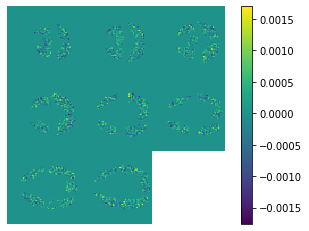

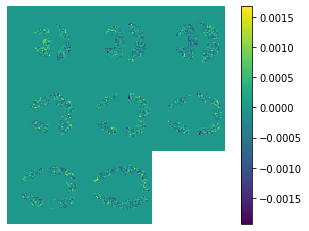

In [6]:
# visualize data
# use the existing tools or write your own!
plt.figure(1)
montage_array(training_data[0, :, :, :, 0], cmap='viridis')
plt.show()
plt.figure(2)
montage_array(test_data[0, :, :, :, 0], cmap='viridis')
plt.show()

In [7]:
# move the label number to second axis
training_data = np.moveaxis(training_data, 0, 1)
test_data = np.moveaxis(test_data, 0, 1)
print(training_data.shape)
print(test_data.shape)

(64, 53, 64, 8, 16)
(64, 27, 64, 8, 16)


In [8]:
# create the boolean array for training and testing
boolean_list = []
for i in (training_labels):
    boolean_list.append(i[0])
boolean_array_training = np.asarray(boolean_list)
print(boolean_array_training)

boolean_list = []
for i in (test_labels):
    boolean_list.append(i[0])
boolean_array_testing = np.asarray(boolean_list)
print(boolean_array_testing)

[1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 1. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1.]


In [9]:
# ==================================================================================================================== #
# form local t-svd
# num_class should be 2
num_classes = len(np.unique(training_labels))
list_a = [('minv', 'banded'),('m','h'),('m','ddm'),('m','ro')]
training_acc_list = []
testing_acc_list = []
trail_list = []
method_list = []
for ii in list_a:
    prod_type = ii[0]
    m_type = ii[1]
    print(str(prod_type) + " " + str(m_type))
    for k in range(1,10):
        U = []
        print(k)
        for i in range(num_classes):
            if prod_type == 'minv':
                u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k=k, prod_type=prod_type, M = (banded_matrix(64,8),banded_matrix(8,2),banded_matrix(16,3)))
                U.append(u)
            elif prod_type == 'm':
                if m_type == 'h':
                    u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k=k, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
                elif m_type == 'ddm':
                    u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k=k, prod_type=prod_type, M = data_dependent_matrix(training_data))
                elif m_type == 'ro':
                    u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k=k, prod_type=prod_type, M = (ortho_group.rvs(64),ortho_group.rvs(8),ortho_group.rvs(16)))
                U.append(u)
        training_error = np.zeros([num_classes, training_data.shape[1]])
        test_error = np.zeros([num_classes, test_data.shape[1]])
        for i in range(num_classes):
            training_projection = projection(training_data, U[i], prod_type=prod_type)
            training_error[i, :] = sm.frobenius_metric(training_data, training_projection, axis=1)

            test_projection = projection(test_data, U[i], prod_type=prod_type)
            test_error[i, :] = sm.frobenius_metric(test_data, test_projection, axis=1)


        # classification
        training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
        test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

        # results

        training_num_correct = np.sum(training_predicted_classes == boolean_array_training)
        training_accuracy = training_num_correct / training_data.shape[1]

        test_num_correct = np.sum(test_predicted_classes == boolean_array_testing)
        test_accuracy = test_num_correct / test_data.shape[1]

        print('train accuracy = %0.2f' % (100 * training_accuracy))
        print('test accuracy = %0.2f' % (100 * test_accuracy))
        
        training_acc_list.append(training_accuracy)
        testing_acc_list.append(test_accuracy)
        trail_list.append(k)
        method_list.append(m_type)
        
print(training_acc_list)
print(testing_acc_list)
print(trail_list)
print(method_list)

minv banded
1
train accuracy = 50.94
test accuracy = 48.15
2
train accuracy = 32.08
test accuracy = 48.15
3
train accuracy = 20.75
test accuracy = 48.15
4
train accuracy = 18.87
test accuracy = 51.85
5
train accuracy = 22.64
test accuracy = 70.37
6
train accuracy = 33.96
test accuracy = 81.48
7
train accuracy = 54.72
test accuracy = 88.89
8
train accuracy = 86.79
test accuracy = 81.48
9
train accuracy = 100.00
test accuracy = 77.78
m h
1
train accuracy = 100.00
test accuracy = 85.19
2
train accuracy = 100.00
test accuracy = 88.89
3
train accuracy = 100.00
test accuracy = 88.89
4
train accuracy = 100.00
test accuracy = 92.59
5
train accuracy = 100.00
test accuracy = 88.89
6
train accuracy = 100.00
test accuracy = 88.89
7
train accuracy = 100.00
test accuracy = 88.89
8
train accuracy = 100.00
test accuracy = 85.19
9
train accuracy = 100.00
test accuracy = 81.48
m ddm
1
train accuracy = 100.00
test accuracy = 81.48
2
train accuracy = 100.00
test accuracy = 92.59
3
train accuracy = 100.00


In [10]:
Merged_Dataset = pd.DataFrame(
    {'number_of_basis_element': trail_list,
     'testing_acc': testing_acc_list,
     'training_acc':training_acc_list,
     'Method': method_list,
    })

In [11]:
new_method_list = ['banded', 'banded', 'banded', 'banded', 'banded', 'banded', 'banded', 'banded', 'banded', 'haar', 'haar', 'haar', 'haar', 'haar', 'haar', 'haar', 'haar', 'haar', 'ddm', 'ddm', 'ddm', 'ddm', 'ddm', 'ddm', 'ddm', 'ddm', 'ddm', 'rand_ortho', 'rand_ortho', 'rand_ortho', 'rand_ortho', 'rand_ortho', 'rand_ortho', 'rand_ortho', 'rand_ortho', 'rand_ortho']
New_Merged_Dataset = pd.DataFrame(
    {'number_of_basis_element': trail_list,
     'testing_acc': testing_acc_list,
     'training_acc':training_acc_list,
     'Method': new_method_list,
    })

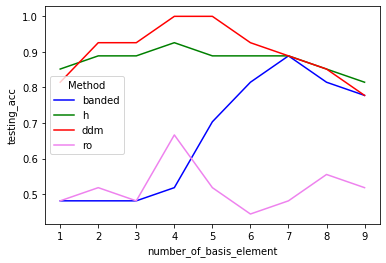

In [12]:
ax = sns.lineplot(x="number_of_basis_element", y="testing_acc", hue = "Method", ci = 'sd', data= Merged_Dataset, palette=['blue','green','red','violet'], sizes=(10, 10), err_style = "band", markers=True)

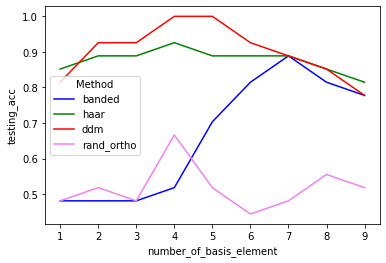

In [17]:
ax = sns.lineplot(x="number_of_basis_element", y="testing_acc", hue = "Method", ci = 'sd', data= New_Merged_Dataset, palette=['blue','green','red','violet'], sizes=(10, 10), err_style = "band", markers=True)
ax.figure.savefig("output.png", dpi = 200)

train accuracy = 100.00
test accuracy = 100.00


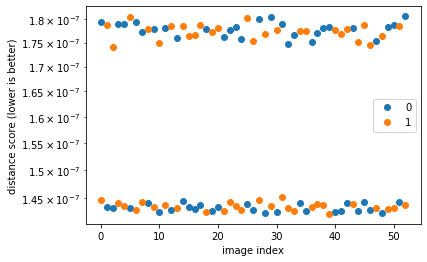

In [12]:
# ==================================================================================================================== #
# compute results on training and test data
training_error = np.zeros([num_classes, training_data.shape[1]])
test_error = np.zeros([num_classes, test_data.shape[1]])
for i in range(num_classes):
    training_projection = projection(training_data, U[i], prod_type=prod_type)
    training_error[i, :] = sm.frobenius_metric(training_data, training_projection, axis=1)

    test_projection = projection(test_data, U[i], prod_type=prod_type)
    test_error[i, :] = sm.frobenius_metric(test_data, test_projection, axis=1)


# classification
training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

# results

training_num_correct = np.sum(training_predicted_classes == boolean_array_training)
training_accuracy = training_num_correct / training_data.shape[1]

test_num_correct = np.sum(test_predicted_classes == boolean_array_testing)
test_accuracy = test_num_correct / test_data.shape[1]

print('train accuracy = %0.2f' % (100 * training_accuracy))
print('test accuracy = %0.2f' % (100 * test_accuracy))

# plot results
plt.figure()
for i in range(num_classes):
    plt.semilogy(training_error[i, :], 'o', label=i)

plt.xlabel('image index')
plt.ylabel('distance score (lower is better)')
plt.legend()
plt.show()

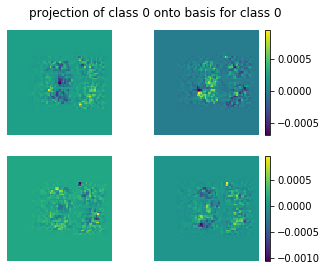

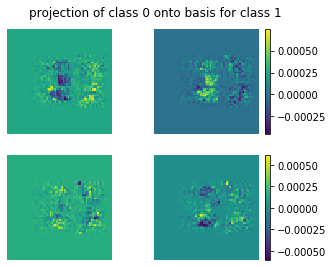

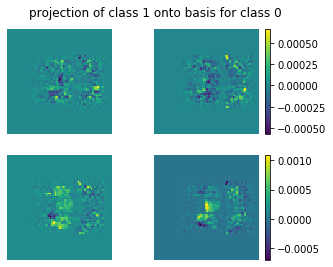

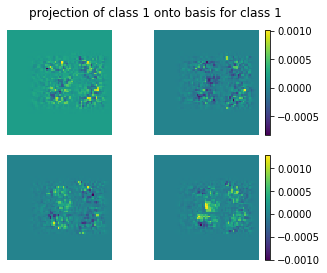

In [13]:
# ==================================================================================================================== #
# visualizations of projected tensors
# use the existing tools or write your own!

for j in range(num_classes):
    for i in range(num_classes):
        A = projection(training_data[:,boolean_array_training == j,:], U[i], prod_type=prod_type)
        slice_subplots(A[:, :4, :,0,0], axis=1, title='projection of class ' + str(j) + ' onto basis for class ' + str(i))
        plt.show()